In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import random
from urllib.parse import urlparse
from collections import Counter
import math
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize
from unicodedata import digit
from sklearn.preprocessing import StandardScaler

In [57]:
df1 = pd.read_csv("malicious_phish.csv")  #malicious_phish.csv #balanced_urls.csv
replacements = {'benign':0,"phishing":1,"defacement":1,"malware":1}
df1['type'] = df1['type'].replace(replacements)
df1.rename(columns={'type': 'labels'}, inplace=True)


df2 = pd.read_csv("balanced_urls.csv")
df2.drop('label', axis=1, inplace=True)
df2.rename(columns={'result': 'labels'}, inplace=True)

In [58]:
def lenght_url(url):
  return len(url)

In [59]:
def length_host(url):
  parsed = urlparse(url)
  if not parsed.netloc:
    if "www" == parsed.path[0:3]:
      stops = parsed.path[4:]
      if stops.find("/") == -1:
        return len(stops)
      else:
        return stops.find("/")
    else:
      stops = len(parsed.path)
      return stops
  else:
    if "www" == parsed.netloc[0:3]:
      stops = parsed.netloc[4:]
      return len(stops)
    else:
      return len(parsed.netloc)

In [60]:
def length_path(url):
    parsed = urlparse(url)
    if not parsed.netloc:
        path = parsed.path.split("/")
        path.pop(0)
        counter = 0
        for i in path:
          counter+=len(i)
        return counter + len(path)
    else:
        return len(parsed.path)

In [61]:
def length_first_dir(url):
    parsed = urlparse(url)
    if not parsed.netloc:
        fist_dir = parsed.path.split("/")
        if len(fist_dir) != 1:
          return len(fist_dir[1])
        else:
          return 0
    else:
        if parsed.path == "":
          return 0
        else:
          fist_dir = parsed.path[1:].split("/")
          return len(fist_dir[0])

In [62]:
def length_top_dom(url):
  parsed = urlparse(url)
  if not parsed.netloc:
    stops = parsed.path.split("/")[0]
    return len(stops.split(".")[-1])
  else:
    return len(parsed.netloc.split(".")[-1])
length_top_dom("www.")

In [63]:
def is_url_shortened(url):
    regex = 'bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|' 'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|' 'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|' 'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|' 'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|' 'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|' 'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|' 'tr\.im|link\.zip\.net'
    short = re.search(regex,url)
    if short:
      return 1
    else:
      return 0

In [64]:
def has_ip(url):
    ips = r'\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b'
    boolean = re.search(ips, url)
    if boolean:
        return 1
    else:
        return 0

In [65]:
def count_feat(url):
  feat = {"dash":0,"at":0,"questions":0,"percentage":0,"fullstop":0,"equal":0,"http":0,"https":0,"www":0,"digits":0,"letters":0,"directories":0}

  for i in url:
    if i=="-" : feat["dash"] += 1
    elif i=="@" : feat["at"] += 1
    elif i=="?" : feat["questions"] += 1
    elif i=="%" : feat["percentage"] += 1
    elif i=="." : feat["fullstop"] += 1
    elif i=="=" : feat["equal"] += 1 
    elif i.isalpha() : feat['letters'] +=1
    elif i in '1234567890' : feat['digits'] +=1
  k=0
  if "http:/" in url:
    feat["http"] += 1
    k=1
  if "https:/" in url:
    feat["https"] += 1
    k=1
  if "www." in url:
    feat["www"] += 1
  dir = url.split('/')
  if '' in dir:dir.remove('')
  feat['directories']=len(dir)-k
  return feat

In [66]:
def generate_set(Z):
  size = len(Z)
  x = np.zeros((size,19))
  for i in tqdm(range(size)):
    url = Z["url"][i]
    feat = count_feat(url)
    x[i][0],x[i][1],x[i][2],x[i][3] = lenght_url(url),length_host(url),length_path(url),length_first_dir(url)
    x[i][4],x[i][5],x[i][6],x[i][7] = length_top_dom(url),has_ip(url),is_url_shortened(url),feat["directories"]
    x[i][8],x[i][9],x[i][10],x[i][11] = feat["dash"],feat["at"],feat["questions"],feat["percentage"]
    x[i][12],x[i][13],x[i][14],x[i][15] =feat["fullstop"],feat["equal"],feat["http"],feat["https"]
    x[i][16],x[i][17],x[i][18] =feat["www"],feat["digits"],feat["letters"]
  return x

In [67]:
x1 = generate_set(df1)
x2 = generate_set(df2)

df = pd.concat([df1, df2], ignore_index=True)
y = df["labels"].to_numpy()

x = np.vstack((x1, x2))


analysis = np.hstack((x, y[:, np.newaxis]))
column_names = ['Url length', 'Host length', 'Path length',"First directory length","Top domain length","IP","Shortened","#Directories","#Dashes","#@","#?","#%","#.","#=","Has http","Has https","Has www","#Digits","#Letters","Labels"]
df_analysis = pd.DataFrame(analysis, columns=column_names)

100%|██████████| 632508/632508 [00:18<00:00, 33508.82it/s]


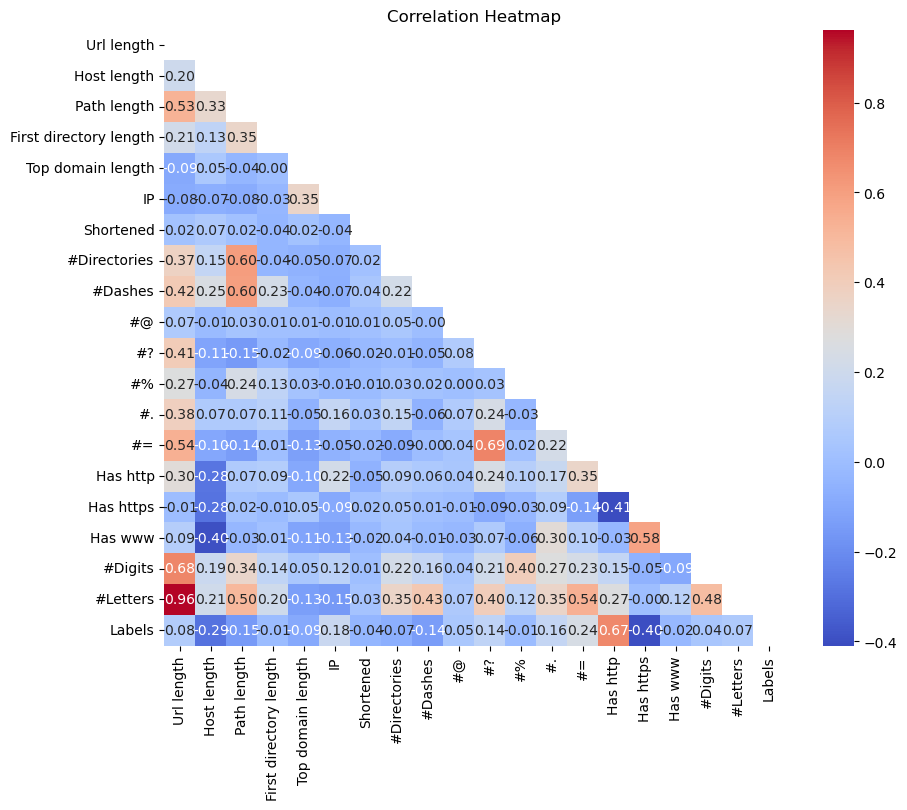

In [68]:
correlation = df_analysis.corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(correlation, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, ax=ax)

plt.title("Correlation Heatmap")

plt.xticks(rotation=90)

plt.show()



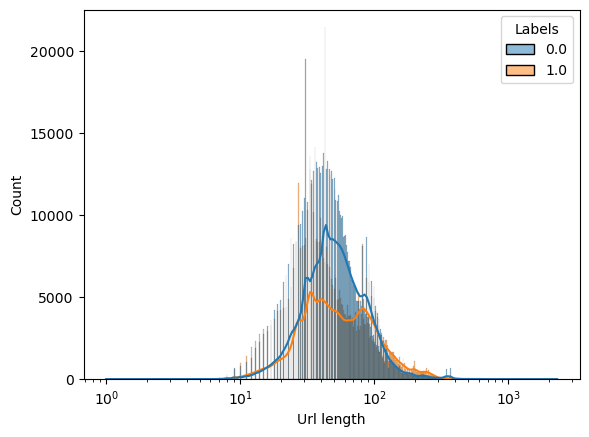

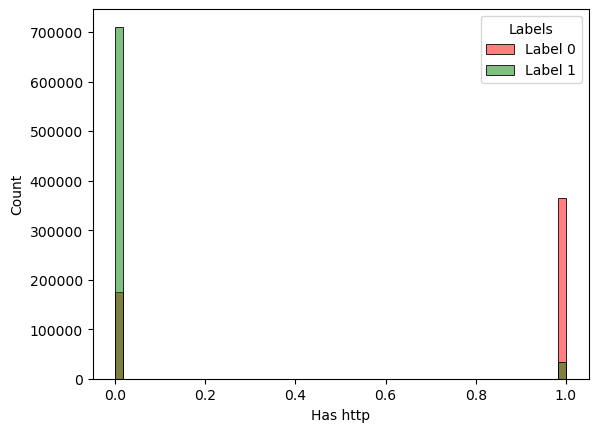

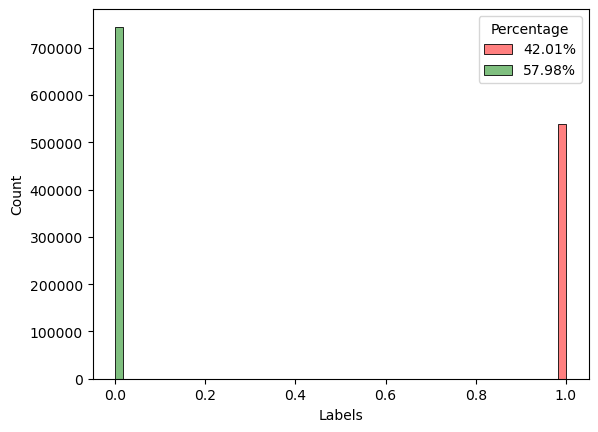

In [69]:
sns.histplot(data=df_analysis, x="Url length",kde=True,hue="Labels", log_scale=True)
plt.show()


sns.histplot(data=df_analysis, x="Has http", hue="Labels", palette={0: "green", 1: "red"})
plt.legend(title='Labels', labels=['Label 0', 'Label 1'])
plt.show()

ones,zeros = 0,0
for i in df_analysis["Labels"]:
    if i == 0:
        zeros+=1
    else:
        ones+=1
        
ones = str(100*ones/len(df_analysis))[:5]+"%"
zeros = str(100*zeros/len(df_analysis))[:5]+"%"
sns.histplot(data=df_analysis, x="Labels",hue="Labels",palette={0: "green", 1: "red"})
plt.legend(title='Percentage',labels=[ones,zeros])
plt.show()



In [70]:
def check_unusual_char(url):
    regex = r'[^a-zA-Z0-9./:-]|(\.\.)|([-]{2,})|(\b(php|asp|aspx|jsp|cgi|html|htm|exe|dll)\b)|(\b\w{32}\b)|(\b\w{16}\b)|(\b\w{8}\b)'
    match = re.search(regex, url)
    if match:
        return 1  # Hyphens or unusual characters found
    else:
        return 0 

In [71]:
def sub_domains(url):
    parsed = urlparse(url)
    if parsed.netloc != "":
        if "www" in parsed.netloc:
            return len(parsed.netloc[4:].split("."))-2
        else:
            return len(parsed.netloc.split("."))-2
    else:
        loc = parsed.path.split('/')[0]
        if "www" in loc:
            return len(loc[4:].split("."))-2
        else:
            return len(loc.split("."))-2

In [72]:
def entropy(url):
    counts = Counter(url)
    frequencies = [i / len(url) for i in counts.values()]
    s = [f * math.log(f, 2) for f in frequencies]
    return  -sum(s)

In [73]:
def check_non_ascii(url):
    boolean = any(ord(char) > 127 for char in url)
    if boolean == True:
        return 1
    else:
        return 0

In [74]:
def check_url_syntax(url):
    syntax_regex = r'^((?:https?|ftp)://)?(?:www\.)?([a-zA-Z0-9-]+(?:\.[a-zA-Z0-9-]+)+)(?:/[^/?#]+)?(?:\?[^#]+)?(?:#.+)?$'
    match = re.match(syntax_regex, url)
    
    if match:
        return 0  
    else:
        return 1

In [94]:
def generate_set_2(Z):
    size = len(Z)
    x = np.zeros((size,24))
    for i in tqdm(range(size)):
        url = Z["url"][i]
        feat = count_feat(url)
        x[i][0],x[i][1],x[i][2] = check_unusual_char(url),sub_domains(url),check_url_syntax(url)
        x[i][3] ,x[i][4],x[i][5] = lenght_url(url),has_ip(url),is_url_shortened(url)
        x[i][6],x[i][7],x[i][8] = feat["http"],feat["digits"],feat["directories"]
        x[i][9],x[i][10],x[i][11] = length_host(url),length_path(url),length_first_dir(url)
        x[i][12],x[i][13],x[i][14] = length_top_dom(url),feat["dash"],feat["at"]
        x[i][15],x[i][16],x[i][17] = feat["questions"],feat["percentage"],feat["fullstop"]
        x[i][18],x[i][19],x[i][20] = feat["equal"],feat["https"],feat["letters"]
        x[i][21],x[i][22],x[i][23] = feat["www"], entropy(url),check_non_ascii(url)
    return x

In [95]:
df_ver2 = pd.concat([df1, df2], ignore_index=True)
x_ver2 = generate_set_2(df_ver2)

100%|██████████| 1283699/1283699 [01:00<00:00, 21087.77it/s]


In [96]:
analysis_ver2 = np.hstack((x_ver2, y[:, np.newaxis]))
column_names_ver2 = ["Unusual char","Has subdomains","Url syntax",
"Url lenght","Has ip","Is shortened",
"Is http","#Digits","#Directories",
"Host lenght","Path lenght","first directory lenght",
"Top domain lenght","#Dash","#@",
"#?","#%","#fullstop",
"#=","Is https","#Letters",
"Has www","Entropy","Non ASCII",
"Labels"]
df_analysis_ver2 = pd.DataFrame(analysis_ver2, columns=column_names_ver2)

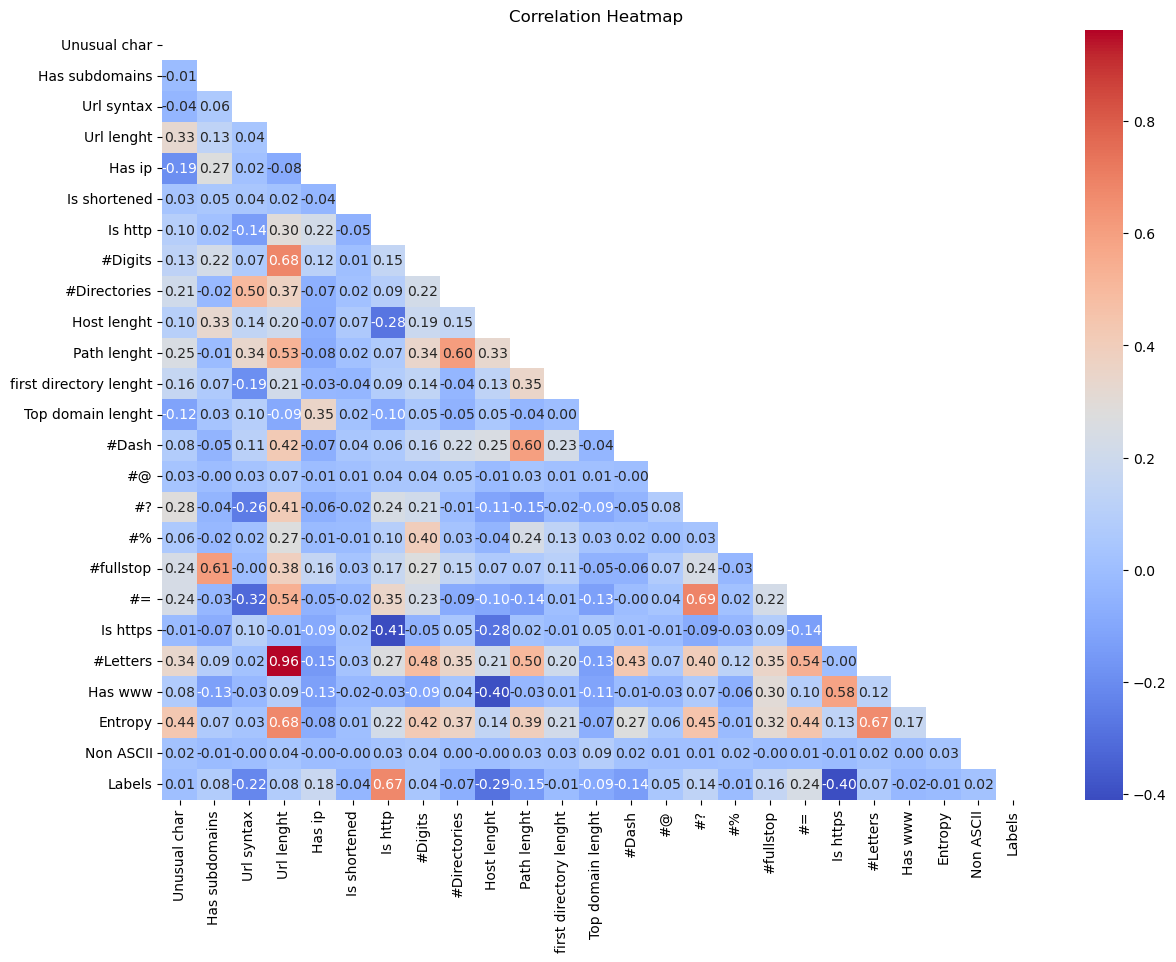

In [97]:
correlation_ver2 = df_analysis_ver2.corr()

mask_ver2 = np.triu(np.ones_like(correlation_ver2, dtype=bool))

fig, ax = plt.subplots(figsize=(14, 10))

sns.heatmap(correlation_ver2, mask=mask_ver2, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, ax=ax)

plt.title("Correlation Heatmap")

plt.xticks(rotation=90)

plt.show()

In [98]:
y_ver2 = df_ver2["labels"].to_numpy()
x_train_ver2, x_test_ver2, y_train_ver2, y_test_ver2 = train_test_split(x_ver2, y_ver2, train_size=0.3, random_state=42)

log_model_ver2 = LogisticRegression(solver='liblinear')
log_model_ver2.fit(x_train_ver2,y_train_ver2)
log_predictions_ver2 = log_model_ver2.predict(x_test_ver2)
print(accuracy_score(y_test_ver2,log_predictions_ver2))

0.8927931537186036


In [99]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.3, random_state=42)

log_model = LogisticRegression(solver='liblinear')
log_model.fit(x_train,y_train)
log_predictions = log_model.predict(x_test)
print(accuracy_score(y_test,log_predictions))

0.8901746068841184
